In [57]:
import numpy as np
import matplotlib.pyplot as plt
import argparse as ap
import csv
import torch.nn.functional as F
import torch.nn as nn
import torch
import glob
import os
import pandas as pd
import random
import math

In [58]:
# Args
# tmd = tech, media and telecom
# hc = healthcare
# cr = consumer and retail
# fig = finnancial institution groups
# ind = industrials
# pnr = power and natural resources


class args:
    sector = "tmd"
    model_save = 'output.txt'
    batch_size = 10
    train_steps = 500
    learning_rate = 0.1
    classes = 2
    cnn_n1_channels = 10 # I hope this works: 05/04/2020
    cnn_n1_kernel = 3
    cnn_n2_kernel = 3
    cnn_n3_kernel = 3
    model = 'simple-cnn'
    log_file = 'logfile.txt'

In [62]:
# Data Reading from raw files

# retval = os.getcwd()
# print(retval)
def loadData():
    path = "/mnt/c/Minted/Data"

    path, dirs, files = next(os.walk(path))
    num_stocks = len(files)
    
    print(num_stocks)
    
    prices = np.zeros((num_stocks, 125))
    price_index = 4 # highs
    iterations = 0
    preds = np.zeros(num_stocks)


    # os.chdir(path)
    for file in glob.glob("*.csv"): 
        i = 126
        this_prices = np.zeros(126)
        with open(file) as csvfile:
            readCSV = csv.reader(csvfile, delimiter=',')
            for row in readCSV:
                ind = (row[price_index].find('$')) + 1
                if i == 126:
                    i -= 1
                    continue
                if i == 125:
                    preds[iterations] = float(row[price_index][ind:])
                    i -= 1
                    continue
                prices[iterations][i] = float(row[price_index][ind:])

                i -= 1

        iterations += 1

    # print(prices.shape)
    # print(prices)

    plt.figure()
    plt.plot(prices[0])
    plt.title("AAPL")

#     plt.figure()
#     plt.plot(prices[1])
#     plt.title("AAPL")



# prices = np.transpose(prices)


In [63]:
# Data Pre-Processing
    # Averaging, getting rid of noise, etc.
    # normalization?
def splitData():
    train_percent = 0.8
    # train_num = math.ceil(0.8 * num_stocks)
    train_num = math.floor(0.8 * num_stocks)
    res = random.sample(range(0, num_stocks), train_num)

    train_data = []
    train_labels = []
    dev_data = []
    dev_labels = []

    for i in range(num_stocks):
        if i in res:
            train_data.append(prices[i])
            train_labels.append(preds[i])
        else:
            dev_data.append(prices[i])
            dev_labels.append(preds[i])


1


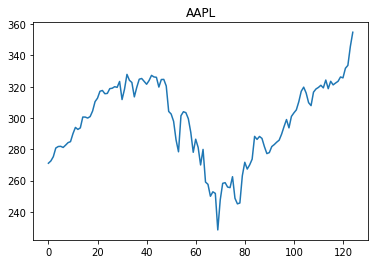

In [64]:
loaded = False
if not loaded:
    loadData()
    splitData()
    np.save("../training_data.npy", train_data)
    np.save("../training_labels.npy", train_labels)
    np.save("../development_data.npy", dev_data)
    np.save("../development_labels.npy", dev_labels)

In [53]:
train_data = np.load("../training_data.npy")
train_labels = np.load("../training_labels.npy")
dev_data = np.load("../development_data.npy")
dev_labels = np.load("../development_labels.npy")

In [ ]:
# Train and predict with neural net

In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, n1_kern, n2_kern, n3_kern, n1_chan):
        super(SimpleCNN, self).__init__()
        # kernel = (n1_kern, n2_kern, n3_kern)
        self.conv1 = torch.nn.Conv2d(1, n1_chan, kernel_size=n1_kern)
        self.conv2 = torch.nn.Conv2d(n1_chan, 2, kernel_size=n2_kern, stride=2)

    def forward(self, x):
        size = x.size()[0]
        x = x.view(size, 1, 512, 512)
        Relu1 = F.relu(self.conv1(x))
        Relu2 = F.relu(Relu1)
        dim3 = Relu2.size()[2]
        dim4 = Relu2.size()[3]
        pool = nn.MaxPool2d((dim3, dim4), stride=2)
        logits = pool(Relu2)
        logits = logits.view(logits.size()[0], 40)
        return logits

In [ ]:
# Data Post Processing

In [ ]:
# Create pattern model to use in tandem with this (probably separate notebook)
# Final predictions